In [2]:
from Genome.goldstandard_pair.lls import *
# read net
gd = '/home/hermuba/data0118/goldstandard/tf_intersect_GO_rm_plasmidGO.smpl'
net = '/home/hermuba/data0118/network1122/combined_rm_plasmid_baye'
gold = read_gold(gd)
all_chunks = read_net_by_chunk(net, names = ['gene_one', 'gene_two', 'combined_score'])
all_chunk = merge_net_with_all_chunks(gold,all_chunks, 'PangenomeNet')

In [3]:
all_chunk.head()

,gene_one,gene_two,goldstandard,combined_lls
0,562.10576.con.0002_214|562.10576,562.22520.con.0081_4|562.22520,0,305.53
1,562.10576.con.0002_214|562.10576,562.22588.con.0052_3|562.22588,0,305.53
2,562.10576.con.0002_214|562.10576,562.22931.con.0021_54|562.22931,0,12.2169
3,562.10576.con.0002_214|562.10576,562.23214.con.0013_144|562.23214,0,3.24758
4,562.10576.con.0002_214|562.10576,562.23322.con.0003_100|562.23322,0,12.2169


In [3]:
all_chunk.to_csv('~/data0118/joined_smpl/pangenomeNet_GO_smpl_rm_plasmid')

In [16]:
# don't need to calculate LLS cause it's done.We need to change LLS threshold and calculate PPV and coverage
def PPV_coverage(lls_thres, all_df):
    '''
    calculate PPV, coverage using different threshold of LLS cutoff
    input: lls_thres: the LLS cutoff to consider interaction as True
    all_df: dataframe containing goldstandard and lls
    '''
    all_df['ans'] = all_df['combined_lls'].map(lambda x: True if x > lls_thres else False)

    # calculate coverage
    total_nodes = set(all_df['gene_one']).union(set(all_df['gene_two']))
    net = all_df.loc[all_df['ans'] == True]
    
   
    covered_nodes = set(net['gene_one']).union(set(net['gene_two']))
    coverage = len(covered_nodes)/len(total_nodes)

    # calculate PPV
    grouped = all_df.groupby(by = ['goldstandard', 'ans']).count()['gene_one']

    try:
        tp = grouped[1, True]
        fp = grouped[0, True]
        PPV = tp/(tp+fp)
    except KeyError:
        PPV = 0
        
    return(coverage, PPV)

def try_diff_lls_thres(all_df):
    '''
    try different LLS threshold to see the tradeoffs between coverage and PPV
    LLS threshold as df['lls'].unique values
    all_df: dataframe containing goldstandard and lls
    '''
    tradeoff = pd.DataFrame(columns = ['thres', 'coverage', 'PPV'])

    #max_score = all_df['combined_lls'].max()
    #min_score = all_df['combined_lls'].min()
    #try_list = np.linspace(start = min_score, stop = max_score, num = 1000)
    try_list = np.sort(all_chunk['combined_lls'].unique())
    
    for t in try_list:
        
        cov, PPV = PPV_coverage(t, all_df)
        tradeoff.loc[t] = [t, cov, PPV]
    return(tradeoff)


In [15]:
all_chunk['combined_lls'].unique()

array([305.53025573,  12.21686447,   3.24758461, ...,  23.06215175,
        12.74183845,  11.82323593])

In [17]:
tradeoff = try_diff_lls_thres(all_chunk)

In [19]:
tradeoff.to_csv('~/data0118/PPV_coverage/combined_rm_plasmid')

Text(0, 0.5, 'PPV')

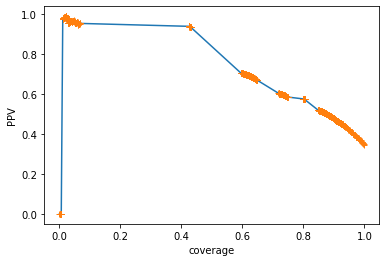

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '-')
plt.plot(tradeoff['coverage'], tradeoff['PPV'], '+')
plt.xlabel('coverage')
plt.ylabel('PPV')